# ResNet

In [1]:
# torch
import torch 
import torch.nn as nn
import torch.optim as optim  
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.transforms import Compose, ToTensor, Resize
from torchvision.datasets import ImageFolder
from torch.utils.data import (
    Dataset,
    DataLoader,
    Subset
) 

# other
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import warnings
from skimage import io
import time
import copy
import cv2
from tqdm import tqdm

warnings.filterwarnings("ignore")

# helper functions
from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix, compute_accuracy, cal_pre_rec
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_dataset import UnNormalize
from data_loading_functions import split_train_test_loaders, show_img, convert_lab
from helper_Gradcam import store_gradcam_image

# Settings

In [2]:
# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0005
BATCH_SIZE = 128
NUM_EPOCHS = 20

# Architecture
NUM_FEATURES = 224*224
NUM_CLASSES = 4

# Other
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GRAYSCALE = False

# Load Data and Preprocessing 

In [3]:
dataset_path = '.\\COVID-19_Radiography_Dataset'
datas, train_loader, valid_loader, test_loader = split_train_test_loaders(dataset_path, batch_size= BATCH_SIZE)

# Display Images

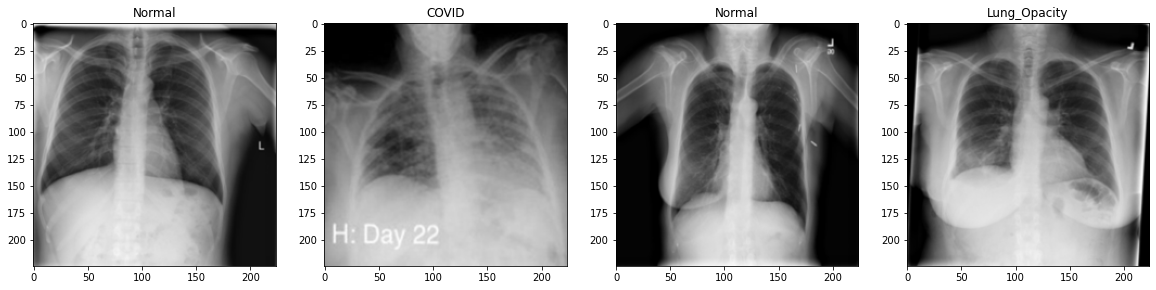

In [4]:
show_img(dataset_path= dataset_path, train= False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


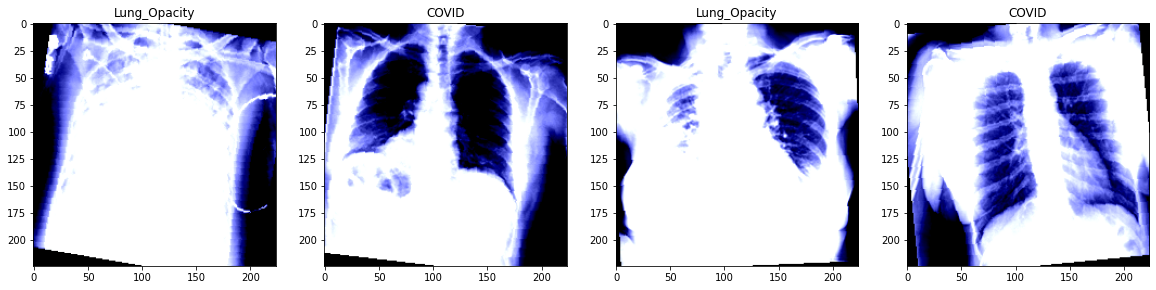

In [4]:
show_img(dataset_path= dataset_path, train= True) 

# Train Model

In [5]:
#  load pretrained models
model_ft = torchvision.models.resnet50(pretrained=True)

#freeze all layers' gradients except layer 3, 4
ct = 0
for child in model_ft.children():
    ct += 1
    if ct < 7:
        for param in child.parameters():
            param.requires_grad = False

# change out_features of last linear layer
model_ft.fc = nn.Linear(in_features=2048, out_features=4, bias=True)                  


# Train
torch.manual_seed(RANDOM_SEED)
model_ft.to(DEVICE)
optimizer = torch.optim.Adam(model_ft.parameters(), lr=LEARNING_RATE)  

minibatch_loss_list_ft, train_acc_list_ft, valid_acc_list_ft = train_model(num_epochs = NUM_EPOCHS, model = model_ft, 
                                                                optimizer = optimizer, device = DEVICE, 
                                                                train_loader = train_loader, valid_loader=valid_loader, 
                                                                test_loader = test_loader, logging_interval=50)

Epoch: 001/020 | Batch 0000/0133 | Loss: 1.3394
Epoch: 001/020 | Batch 0050/0133 | Loss: 0.3790
Epoch: 001/020 | Batch 0100/0133 | Loss: 0.1925
Epoch: 001/020 | Train: 93.48% | Validation: 92.91%
Time elapsed: 3.25 min
Epoch: 002/020 | Batch 0000/0133 | Loss: 0.2017
Epoch: 002/020 | Batch 0050/0133 | Loss: 0.1314
Epoch: 002/020 | Batch 0100/0133 | Loss: 0.2056
Epoch: 002/020 | Train: 94.22% | Validation: 92.91%
Time elapsed: 6.23 min
Epoch: 003/020 | Batch 0000/0133 | Loss: 0.1383
Epoch: 003/020 | Batch 0050/0133 | Loss: 0.2182
Epoch: 003/020 | Batch 0100/0133 | Loss: 0.2451
Epoch: 003/020 | Train: 87.82% | Validation: 87.86%
Time elapsed: 9.20 min
Epoch: 004/020 | Batch 0000/0133 | Loss: 0.0736
Epoch: 004/020 | Batch 0050/0133 | Loss: 0.2174
Epoch: 004/020 | Batch 0100/0133 | Loss: 0.1284
Epoch: 004/020 | Train: 95.00% | Validation: 93.95%
Time elapsed: 12.14 min
Epoch: 005/020 | Batch 0000/0133 | Loss: 0.1232
Epoch: 005/020 | Batch 0050/0133 | Loss: 0.0898
Epoch: 005/020 | Batch 0100

In [6]:
torch.save(model_ft, os.path.join('.\\models', 'Resnet50_bs128_epoch20_oldnorm.pth'))

# Evaluation 

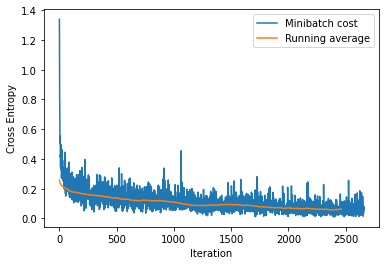

In [7]:
plt.plot(minibatch_loss_list_ft, label='Minibatch cost')
plt.plot(np.convolve(minibatch_loss_list_ft, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

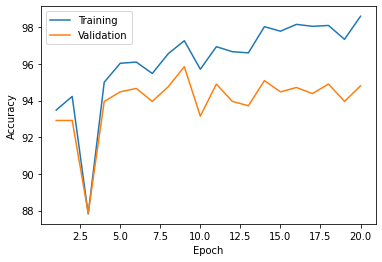

In [8]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list_ft, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list_ft, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

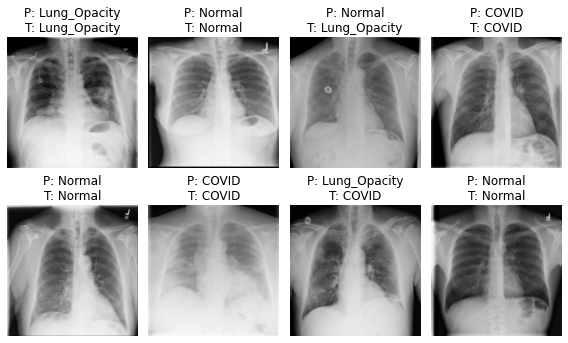

In [11]:
model_ft.cpu()
unnormalizer = UnNormalize((0.4363, 0.4328, 0.3291), (0.2129, 0.2075, 0.2038))
class_dict  = {0: 'COVID', 1: 'Lung_Opacity', 2: 'Normal', 3: 'Viral Pneumonia'}

show_examples(model=model_ft, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)

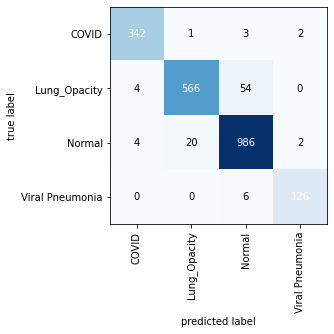

In [10]:
class_dict  = {0: 'COVID', 1: 'Lung_Opacity', 2: 'Normal', 3: 'Viral Pneumonia'}
model_ft.to(DEVICE)

mat = compute_confusion_matrix(model=model_ft, data_loader=test_loader, device=DEVICE)
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

# Precision, Recall, F1


In [6]:
cal_pre_rec(mat)

COVID => Precision: 98.28%, Recall: 97.71%, F1: 97.99%
-----------------
Lung_Opacity => Precision: 90.71%, Recall: 96.42%, F1: 93.48%
-----------------
Normal => Precision: 97.43%, Recall: 93.99%, F1: 95.68%
-----------------
Viral Pneumonia => Precision: 95.45%, Recall: 96.92%, F1: 96.18%
-----------------


# Grad Cam

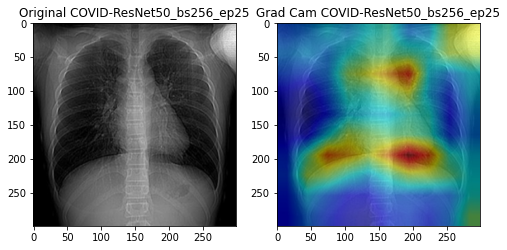

In [63]:
model_ft = torch.load(os.path.join('.\\models', 'Resnet50_bs128_epoch20_oldnorm.pth'))
model_ft.to(DEVICE)

# unfreeze gradients
ct = 0
for child in model_ft.children():
    ct += 1
    if ct < 7:
        for param in child.parameters():
            param.requires_grad = True


# Parameters 
feature_module = model_ft.layer4
target_layer = ['2']
model_name = 'ResNet50_bs256_ep25' ## Name for your plt title
class_name = 'COVID' 
index = 121

## this function will save image in grad_cam_images folder
store_gradcam_image(model_ft, feature_module, target_layer, model_name, class_name, index)